In [ ]:
!pip install shap transformers --quiet

In [ ]:
import shap
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Carregar modelo BERT pré-treinado para análise de sentimentos
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
# 2. Frase de exemplo
frase = "O curso de XAI na Alura foi absolutamente maravilhoso para minha carreira. Espetacular !!"

# 3. Tokenização
inputs = tokenizer([frase], return_tensors="pt", padding=True, truncation=True)

In [ ]:
with torch.no_grad():
    output = model(**inputs)
    probabilities = torch.nn.functional.softmax(output.logits, dim=-1)
    predicted_class = torch.argmax(probabilities).item()
    confidence = torch.max(probabilities).item()

print(f"Frase: \"{frase}\"")
print(f"Predição do modelo: Classe {predicted_class + 1}/5 – Confiança: {confidence:.2f}")


Frase: "O curso de XAI na Alura foi absolutamente maravilhoso para minha carreira. Expetacular !!"
Predição do modelo: Classe 5/5 – Confiança: 0.91


In [ ]:
def predict_proba(texts):
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    elif isinstance(texts, str):
        texts = [texts]

    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)

    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.numpy()



In [ ]:
masker = shap.maskers.Text()

explainer = shap.Explainer(predict_proba, masker)

In [ ]:
# Gerar explicação
frase = ["O curso de XAI na Alura foi absolutamente maravilhoso para minha carreira. Expetacular !!"]
shap_values = explainer(frase)

  0%|          | 0/156 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:13, 13.79s/it]               


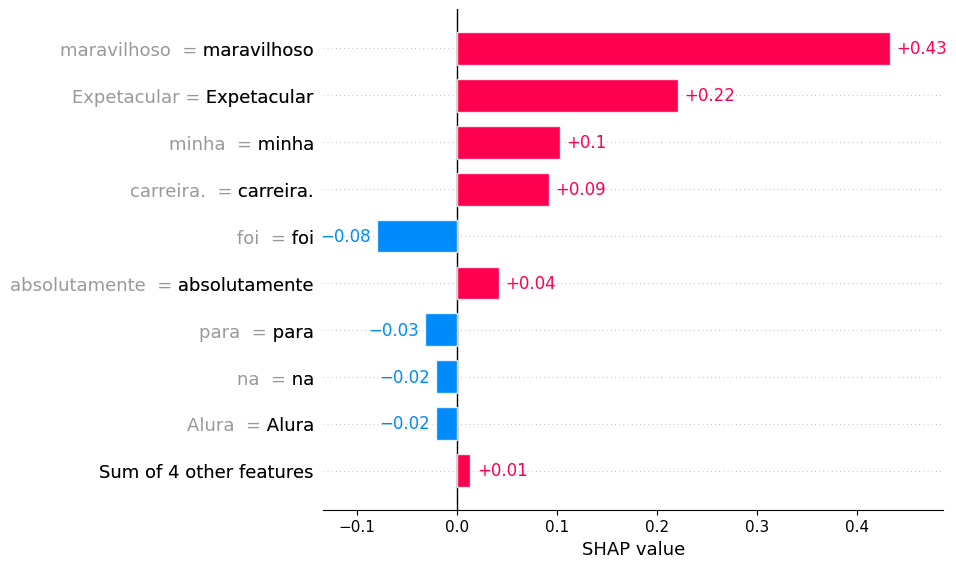

In [ ]:
# 1. Escolher a classe com maior soma absoluta dos valores SHAP
classe_idx = np.argmax(np.sum(np.abs(shap_values[0].values), axis=0))

# 2. Extrair os valores SHAP para essa classe
shap_vals_1d = shap_values[0].values[:, classe_idx]

# 3. Criar novo Explanation para a classe selecionada
exp = shap.Explanation(
    values=shap_vals_1d,
    data=shap_values[0].data,
    feature_names=shap_values[0].feature_names
)

# 4. Plotar o gráfico de barras
shap.plots.bar(exp)